In [1]:
import numpy as np
import dxchange
import holotomo
import matplotlib.pyplot as plt

%matplotlib inline

# Init data sizes and parametes of the PXM of ID16A

In [2]:
n = 384  # object size in x,y
ntheta = 1  # number of angles (rotations)

pn = n # tomography chunk size for GPU processing (dont change if data is small and fits gpu memory)
ptheta = 1 # holography chunk size for GPU processing

center = n/2 # rotation axis
theta = np.linspace(0, np.pi, ntheta).astype('float32') # projection angles

# ID16a setup
voxelsize = 10e-9*2048/n # [m] object voxel size 
energy = 33.35  # [keV] x-ray energy    
focusToDetectorDistance = 1.28 # [m]
sx0 = 3.7e-4 # [m] motor offset from the focal spot
z1 = np.array([4.584,4.765,5.488,6.9895])*1e-3-sx0 # distances between planes and the focal spot
z2 = focusToDetectorDistance-z1 # distances between planes and the detector
magnifications = focusToDetectorDistance/z1 # actual magnifications
norm_magnifications = magnifications/magnifications[0] # normalized magnifications
distances = (z1*z2)/focusToDetectorDistance # propagation distances after switching from the point source wave to plane wave,
distances = distances*norm_magnifications**2 # scaled propagation distancesc due to magnified probes

## Generate phantom data as a set of ellipses

In [3]:
import xraylib
delta_m1 = -(1-xraylib.Refractive_Index_Re('(C5O2H8)n',energy,1.18)) #density
beta_m1 = xraylib.Refractive_Index_Im('(C5O2H8)n',energy,1.18)
delta_m2 = -delta_m1#-(1-xraylib.Refractive_Index_Re('H2O',energy,1))
beta_m2 = -beta_m1#xraylib.Refractive_Index_Im('H2O',energy,1)

print(delta_m1,beta_m1)
print(delta_m2,beta_m2)

ellipses = [[delta_m1+1j*beta_m1, 0.4, 0.4, 0.4, 0,0,0,0],
            [delta_m2+1j*beta_m2, 0.2, 0.35, 0.35, 0,0,0,0]]

 
# Blank image
u = np.zeros ((n, n, n),dtype='complex64')

# Create the pixel grid
zgrid, ygrid, xgrid = np.mgrid[-1:1:(1j*n), -1:1:(1j*n), -1:1:(1j*n)]

for ellip in ellipses:
    I   = ellip[0] #
    a2  = ellip [1]**2
    b2  = ellip [2]**2
    b3  = ellip [3]**2
    x0  = ellip [4]
    y0  = ellip [5]
    z0  = ellip [6]
    phi = ellip [7] * np.pi / 180  # Rotation angle in radians
    
    # Create the offset x and y values for the grid
    x = xgrid - x0
    y = ygrid - y0
    z = zgrid - z0
    
    cos_p = np.cos (phi) 
    sin_p = np.sin (phi)
    
    # Find the pixels within the ellipse
    locs = (((x * cos_p + y * sin_p)**2) / a2 
          + ((y * cos_p - x * sin_p)**2) / b2
          + (z**2) / b3)<= 1
    
    # Add the ellipse intensity to those pixels
    u [locs] += I

-2.3754525801944482e-07 9.488849121350568e-11
2.3754525801944482e-07 -9.488849121350568e-11


NameError: name 'nz' is not defined

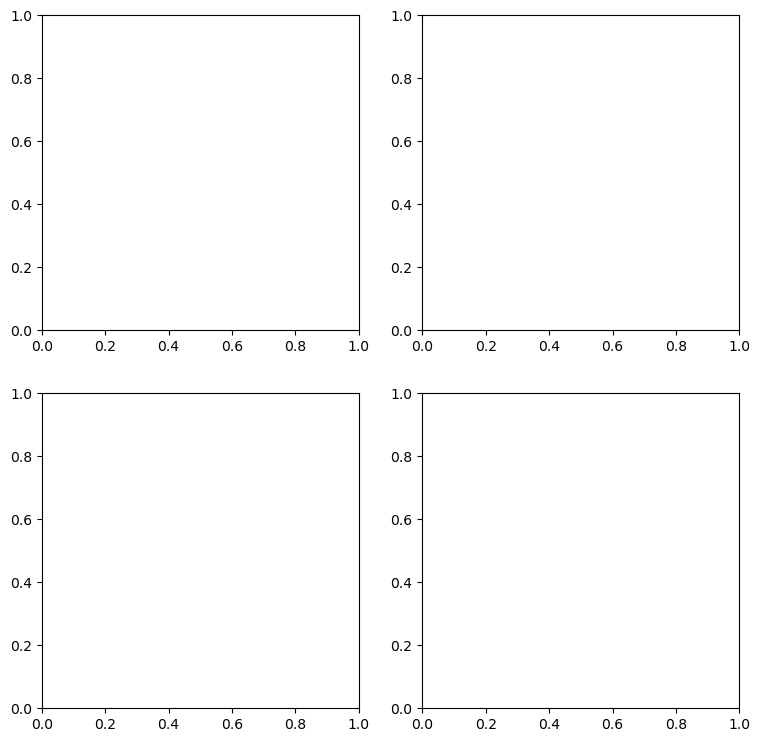

In [4]:
fig, axs = plt.subplots(2, 2, figsize=(9, 9))
im=axs[0,0].imshow(u[n//2].real,cmap='gray')
fig.colorbar(im)
im=axs[0,1].imshow(u[n//2].imag,cmap='gray')
fig.colorbar(im)
im=axs[1,0].imshow(u[:,n//2+n//8].real,cmap='gray')
fig.colorbar(im)
im=axs[1,1].imshow(u[:,n//2+n//8].imag,cmap='gray')
fig.colorbar(im)

Note that in this formation delta is negative

## Create a solver class for tomography

In [ ]:
tslv = holotomo.SolverTomo(theta, ntheta, n, n, pn, center)

note pnz parameter is used to define the number of slices for simultaneous processing by 1 gpu. Currently pnz=nz. If the gpu does not have enough memory then pnz should  be decreased

## Create a solver class for holography

In [ ]:
pslv = holotomo.SolverHolo(ntheta, n, ptheta, voxelsize, energy, distances, norm_magnifications)

note ptheta parameter is used to define the number of angles for simultaneous processing by 1 gpu. Currently pntheta=ntheta. If the gpu does not have enough memory then ptheta should  be decreased
norm_magnifications are magnifications for different distances, normalized by the magnification for the first distance

## Compute tomographic projection data via the Fourier based method, $\mathcal{R}u$:

In [ ]:
Ru = tslv.fwd_tomo_batch(u)

## Convert it to the transmittance function $e^{\frac{2\pi j}{\lambda} \mathcal{R} u }$

In [ ]:
psi = pslv.exptomo(Ru)


In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(9, 4))
im=axs[0].imshow(np.abs(psi[0]),cmap='gray')
fig.colorbar(im)
im=axs[1].imshow(np.angle(psi[0]),cmap='gray')
fig.colorbar(im)

## Read reference images (probes) recovered by the NFP (Near-field ptychogarphy) method at ID16A. There are probes for 4 different distances.

In [ ]:
prb_abs = dxchange.read_tiff(f'data/prb_id16a/prb_abs_{n}.tiff')[:1]
prb_phase = dxchange.read_tiff(f'data/prb_id16a/prb_phase_{n}.tiff')[:1]
prb = prb_abs*np.exp(1j*prb_phase)    

# simplify test by using prb=1
prb[:] = 1

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(9, 5))
im=axs[0].imshow(np.abs(prb[0]),cmap='gray')
axs[0].set_title('scaled probe at z1[0], amplitude')
fig.colorbar(im)
im=axs[1].imshow(np.angle(prb[0]),cmap='gray')
axs[1].set_title('scaled probe at z1[0], phase')
fig.colorbar(im)


# Compute holographic projections for all angles and all distances

In [ ]:
psie = np.pad(psi,((0,0),(n//2,n//2),(n//2,n//2)),'constant',constant_values=1)
fpsi = pslv.fwd_holo_batch(psie,prb)
fflat = pslv.fwd_holo_batch(psie*0+1,prb) 
fpsi0 = pslv.fwd_holo_batch(psie,prb*0+1)

## Take squared absolute value to simulate data on the detector, flat fields, and data with homogeneous flat fields  

In [ ]:
data = np.abs(fpsi)**2
flat = np.abs(fflat)**2
data0 = np.abs(fpsi0)**2

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(9, 9))
im=axs[0,0].imshow(data[0,0]/flat[0,0],cmap='gray')
axs[0,0].set_title('data/flat')
fig.colorbar(im)
im=axs[0,1].imshow(data0[0,0],cmap='gray')
axs[0,1].set_title('data0 generated with flat==1')
fig.colorbar(im)
im=axs[1,0].imshow(data[3,0],cmap='gray')
axs[1,0].set_title('data')
fig.colorbar(im)
im=axs[1,1].imshow(data[0,0]/flat[0,0]-data0[0,0],cmap='gray')
axs[1,1].set_title('data/flat - data0')
fig.colorbar(im)

# Save data

In [ ]:
for k in range(len(distances)):
    dxchange.write_tiff(data[k],f'data/modeling/data_phantom_{n}_{k}',overwrite=True)
for k in range(len(distances)):
    dxchange.write_tiff(flat[k,0],f'data/modeling/flat_phantom_{n}_{k}',overwrite=True)